# Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
train_df = pd.read_csv('train.csv')

In [11]:
train_df.shape

(159571, 8)

In [4]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_df.drop('id', axis=1, inplace=True)

In [6]:
train_df['comment_text'] = train_df['comment_text'].apply(lambda x:x.replace('\n', ' ').strip())

In [7]:
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,""" More I can't make any real suggestions on im...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Train Test Splitting

In [8]:
from sklearn.model_selection import train_test_split

X = train_df['comment_text']
y = train_df.drop('comment_text', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y['severe_toxic'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101, stratify=y_train['severe_toxic'])

In [ ]:
X_train.shape

(48000,)

# Model Training

In [9]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [16]:
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1")

In [17]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess_model(text_input)
outputs = bert_model(preprocessed_text)

# Neural network layers
drop1 = tf.keras.layers.Dropout(0.2, name="dropout1")(outputs['pooled_output'])
h1 = tf.keras.layers.Dense(48, activation='relu', name="hidden1")(drop1)
drop2 = tf.keras.layers.Dropout(0.1, name="dropout2")(h1)
h2 = tf.keras.layers.Dense(24, activation='relu', name="hidden2")(drop2)
drop3 = tf.keras.layers.Dropout(0.1, name="dropout3")(h2)
h3 = tf.keras.layers.Dense(12, activation='relu', name="hidden3")(drop3)
out = tf.keras.layers.Dense(6, activation='sigmoid', name="output")(h3)

# Final model
model = tf.keras.Model(inputs=[text_input], outputs = [out])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_recall",
    min_delta=0.01,
    patience=10,
    verbose=1,
    mode="max",
    baseline=None,
    restore_best_weights=True
)

In [24]:
import os

path_checkpoint = "model_cp.ckpt"
directory_checkpoint = os.path.dirname(path_checkpoint)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                                 save_weights_only=True,
                                                 verbose=1)

In [25]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [26]:
history = model.fit(X_test, y_test, batch_size=16 ,epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

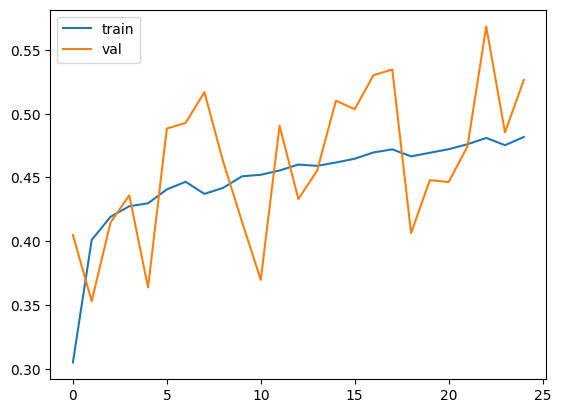

In [ ]:
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='val')
plt.legend()

In [ ]:
model.evaluate(X_test, y_test)

469/469 [==============================] - 81s 171ms/step - loss: 0.0655 - accuracy: 0.9951 - precision: 0.7548 - recall: 0.5484


[0.06547798961400986,
 0.9951333403587341,
 0.7547892928123474,
 0.5484070777893066]

In [ ]:
model.save('model')

# Model Usage

In [ ]:
!pip install gradio jinja2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 11.4

In [ ]:
!pip install typing_extensions --upgrade

In [27]:
!pip install tensorflow_text

ERROR: Could not find a version that satisfies the requirement tensorflow_text (from versions: none)
ERROR: No matching distribution found for tensorflow_text

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [23]:
from keras.models import load_model
import tensorflow_text as text

ModuleNotFoundError: No module named 'tensorflow_text'

In [10]:
!zip -r ../models/toxicity.zip /model

  adding: toxicity/ (stored 0%)


In [14]:
import tensorflow as tf

In [21]:
model = tf.keras.models.load_model('toxicity_model/model4')

RuntimeError: Op type not registered 'CaseFoldUTF8' in binary running on Prathams-MacBook-Pro.local. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib (e.g. `tf.contrib.resampler`), accessing should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.

In [17]:
def score_comment(comment):
    results = model.predict([comment])

    columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate']

    text = ''
    for id, col in enumerate(columns):
        text += '{}: {} | score: {:.2f}%\n'.format(col, results[0][id]>0.5, results[0][id]*100)

    return text

In [18]:
score_comment("I am good")

ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=string>]


In [ ]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.components.Textbox(lines=8, placeholder='Comment to score'),
                        outputs='text')

In [ ]:
interface.launch(share=True)

# HuggingFace Model

In [47]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
text = "I like this"

encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) positive 0.8533
2) neutral 0.1322
3) negative 0.0146


array([0.07876013, 0.66089165, 0.26034814], dtype=float32)

In [36]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("unitary/toxic-bert")
model = AutoModelForSequenceClassification.from_pretrained("unitary/toxic-bert")

KeyboardInterrupt: 